# Utility Functions

In [56]:
# type annotations
from typing import List, Set, Tuple
from datetime import datetime, date
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
from praw import Reddit
from psaw import PushshiftAPI
from collections import Counter
import spacy
from spacy.lang.en import English
from spacy.tokens import DocBin
from spacy.tokens import Doc

nlp = spacy.load("en_core_web_sm")

In [2]:
def word_per_year(df: pd.DataFrame, words: List[str], time_str) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    times: List[str] = list(df[time_str].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda time: df.loc[df[time_str] == time, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(time) for time in times]
    return pd.DataFrame({time_str: times, "word_counts": word_counts})


def append_wc(df: pd.DataFrame, words: List[List[str]], time_str: str) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, time_str)), words, pd.DataFrame())
    nyear = df[time_str].unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df

def user_ents(u: str):
    """Get all entities associated with a given user."""
    grouped_ents = ents_df.loc[ents_df["username"] == u, :]["ents"].tolist()
    return ft.reduce(lambda x, y: x + y, grouped_ents, [])


def ents_by_type(ents, etype):
    """Get the text for entities of the given type from the given ents."""
    etypes = [e.text.lower().strip(".") for e in ents if e.label_ == etype]
    return etypes


def row_with_kw(df: pd.DataFrame, kw: str):
    """Returns row indexes of dataframe with ents with the given keyword."""
    return [i for i, ents in enumerate(ents_df["ents"].tolist()) 
            if kw in [str(e).lower() for e in ents]]

def disk_to_spacy(fp: str) -> List[English]:
    """Read spacy documents from disk."""
    docbin = DocBin().from_bytes(open(fp, "rb").read())
    disk_docs = docbin.get_docs(nlp.vocab)
    disk_docsl = list(disk_docs)
    return disk_docsl

def df_by_ent(df, e_name):
    """subset an entity df by the given ent."""
    sub_df = df.copy()
    sub_df[e_name] = sub_df["ents"].apply(lambda ents: [e for e in ents if e.label_ == e_name])
    sub_df[e_name] = sub_df[e_name].apply(lambda ents: ents if len(ents) > 0 else None)
    return sub_df.dropna()

def df_by_user(df, user):
    return df.loc[df["username"] == user, :]

def top_ents(df, e_name):
    """Get most frequent entities"""
    names = [e.text.lower() for e in list(it.chain.from_iterable(df[e_name].tolist()))]
    return Counter(names)

def search_ent(df, word, e_name):
    return


# Read in data

In [46]:
import pymongo
import os
from dotenv import load_dotenv

# define project location
PROJ_DIR = "."

# load local environment variables
ENV_PATH = os.path.join(PROJ_DIR, ".env")
load_dotenv(dotenv_path=ENV_PATH)

# define mongo connection
mongo = pymongo.MongoClient(os.getenv("HOST"),
                            int(str(os.getenv("PORT"))),
                            username=os.getenv("MUSERNAME"),
                            password=os.getenv("MPASSWORD"),
                            authSource=os.getenv("DB_NAME"))
db = mongo[os.getenv("DB_NAME")]
coll = db[os.getenv("COLL_NAME")]
test_coll = db[os.getenv("TEST_COLL_NAME")]

In [4]:
# general processing
import pymongo
from tqdm import tqdm
from collections import Counter

In [57]:
def bytes_to_spacy(data: bytes, nlp: English) -> Doc:
    """Convert byte data to a spacy doc."""
    doc = Doc(nlp.vocab).from_bytes(data)
    return doc

In [7]:
# read in full mongo collection
res = coll.find({})
df = pd.DataFrame(res)

In [44]:
# load random users from csv
rand_users = pd.read_csv("~/projects/dp-scheduler/data/rand_user_200.csv", header=None, squeeze=True).tolist()

In [48]:
# get full histories for rand users
rand_histories = list(coll.find({"username": {"$in": rand_users}}))

In [73]:
# convert histories to df
hist_df = pd.DataFrame(rand_histories)

In [78]:
hist_df["spacy"] = hist_df["spacy"].apply(lambda x: bytes_to_spacy(x, nlp) if type(x) == bytes else None)

# User Histories

In [12]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

## User Plots

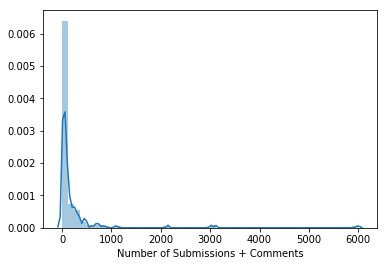

In [69]:
user_counts = hist_df.groupby("username").count().sort_values("_id").reset_index()
ax = sns.distplot(user_counts["_id"].tolist())
ax.set(xlabel="Number of Submissions + Comments")
plt.show()

## Extract entities

In [80]:
hist_df["ents"] = hist_df["spacy"].apply(lambda sp: list(sp.ents) if (sp and len(sp.ents) > 0) else None)
hist_df = hist_df.dropna()

In [81]:
# extract gpe locations
gpe_df = df_by_ent(hist_df, "GPE")

In [82]:
top_ents(df_by_user(gpe_df, "MetroMaker"), "GPE").most_common()

[]

In [83]:
pd.set_option('display.max_colwidth', -1)
gpe_df.loc[:, ["username", "subreddit", "GPE", "text", ]]

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,username,subreddit,GPE,text


## Explore entities by user

In [18]:
flat_ents = ft.reduce(lambda x, y: x + y, ents_df["ents"].tolist(), [])

NameError: name 'ents_df' is not defined

In [19]:
# get observations with ents that match a keyword
atlanta_idx = row_with_kw(ents_df, "atlanta")
atlanta_df = ents_df.iloc[atlanta_idx, :]

NameError: name 'ents_df' is not defined

In [347]:
# get entities for a given user
u1_ents = user_ents("realcat67")
u1_gpe = ents_by_type(u1_ents, "GPE")

## Extract User Locations

In [20]:
# group all gpe per user
def agg_gpe(gpes):
    return dict(Counter(it.chain.from_iterable(gpes)))
gpe_df["locs"] = gpe_df["GPE"].apply(lambda x: [e.text.lower() for e in x])
user_loc_df = gpe_df.loc[:,["username", "locs"]].groupby("username").agg(agg_gpe)

In [21]:
# city/state records
# source: https://github.com/grammakov/USA-cities-and-states
city_state_df = pd.read_csv("data/cities-states.csv", sep="|").dropna()
city_state_df["city"] = city_state_df["City"].apply(lambda x: x.lower())
city_state_df["state"] = city_state_df["State full"].apply(lambda x: x.lower())
city_state_df["county"] = city_state_df["County"].apply(lambda x: x.lower())

In [22]:
denylist = ["china", "russia", "turkey", "op"]
def check_locs(loc_df, city_df):
    for c in ["city", "state", "county"]:
        loc_df[c] = loc_df["locs"]\
        .apply(lambda x: sorted([(k, v) for k, v in x.items() 
                                 if k in city_df[c].tolist() and k not in denylist], 
                                key=lambda x: x[1],
                                reverse=True))
    return loc_df

In [23]:
# assign states, cities, counties per user
locs_df = check_locs(user_loc_df, city_state_df)

In [24]:
city_state_df.head()

,City,State short,State full,County,City alias,city,state,county
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service,holtsville,new york,suffolk
1,Holtsville,NY,New York,SUFFOLK,Holtsville,holtsville,new york,suffolk
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin,adjuntas,puerto rico,adjuntas
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas,adjuntas,puerto rico,adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante,adjuntas,puerto rico,adjuntas


In [25]:
# query city/state df
city_state_df.loc[city_state_df["city"] == "canada",:]

,City,State short,State full,County,City alias,city,state,county
28997,Canada,KY,Kentucky,PIKE,Canada,canada,kentucky,pike


In [26]:
locs_df = locs_df.reset_index()

In [27]:
city_blist = city_state_df["state"].unique().tolist() + ["canada", "united states", "mexico", "brazil", "peru", "bolivia"]
locs_df["filt_city"] = locs_df["city"].apply(lambda x: [i for i in x if i[0] not in city_blist])

In [28]:
pd.set_option('display.max_rows', None)
locs_df

,username,locs,city,state,county,filt_city
0,1494,{'ma': 1},[],[],[],[]
1,40throw,"{'soooo': 4, 'comolbia': 1, 'sciatica': 1, 'us': 38, 'cl': 1, 'feniltoloxamina': 2, 'ecuador': 24, 'chile': 11, 'turkey': 4, 'colombia': 10, 'peru': 15, 'klonazepam': 1, '\[eru': 1, 'la': 4, 'argentina': 3, 'brazil': 4, 'uruguay': 1, 'bolivia': 2, 'narcanme': 1, 'nomad': 1, 'grande': 1, 'denver': 1, 'xanax': 10, 'jj': 1, 'iraq': 1, 'mastro': 1, 'charleston': 1, 'tijuana': 1, 'san lucas': 1, 'drymouth': 1, 'florida': 1, 'england': 1, 'venezuela': 2, 'cambodia': 1, 'indonesia': 2, 'spain': 1, 'latina': 1, 'carlin': 1, 'mucho': 3, 'marijuana': 2, 'cuba': 2, 'china': 1, 'costa rica': 1, 'san pedro': 1, 'ketamine': 1, 'vietnam': 1, 'california': 2, 'oregon': 3, 'valium': 1, 'elberfeld': 1, 'germany': 2, 'australia': 1, '¿': 1, 'agorophobia': 1, 'le': 2, 'japan': 1, 'tiawan': 1, 'thailand': 1, 'lorazepam': 1, 'manhattan': 2, 'washington heights': 1, 'uk': 2, 'ohio': 8, 'alaska': 2, 'doomsday': 1, 'hawaii': 1, 'afghanistan': 2, 'finland': 1, 'catawba county': 1, 'switzerland': 1, 'utah': 1, 'poland': 1, 'lots': 1, 'portland': 1, 'the united states': 1, 'doriden': 1, 'asprin': 1, 'multiday': 1, 'canada': 1, 'rome': 1, 'bawston': 1, 'kipns': 1, 'st louis': 1, 'missouri': 1, 'knockin': 1, 'morocco': 1, 'mexico': 1, 'baja': 1, 'portugal': 1, 'mj': 1, 'sf': 1}","[(peru, 15), (ohio, 8), (la, 4), (brazil, 4), (oregon, 3), (bolivia, 2), (cuba, 2), (california, 2), (manhattan, 2), (denver, 1), (charleston, 1), (san lucas, 1), (florida, 1), (england, 1), (carlin, 1), (san pedro, 1), (elberfeld, 1), (finland, 1), (poland, 1), (portland, 1), (canada, 1), (rome, 1), (morocco, 1), (mexico, 1), (sf, 1)]","[(ohio, 8), (oregon, 3), (california, 2), (alaska, 2), (florida, 1), (hawaii, 1), (utah, 1), (missouri, 1)]","[(ohio, 8), (oregon, 3), (denver, 1), (charleston, 1), (florida, 1), (hawaii, 1), (switzerland, 1), (utah, 1)]","[(la, 4), (cuba, 2), (manhattan, 2), (denver, 1), (charleston, 1), (san lucas, 1), (england, 1), (carlin, 1), (san pedro, 1), (elberfeld, 1), (finland, 1), (poland, 1), (portland, 1), (rome, 1), (morocco, 1), (sf, 1)]"
2,980ti,"{'ram': 1, 'itunes': 1, 'india': 2, 'kools': 1, 'ls': 1, 'israel': 8, 'kentucky': 6, 'satan': 1, 'america': 38, 'st louis': 1, 'netflix': 2, 'soros': 2, 'us': 26, 'uk': 2, 'xanax': 3, '150ug': 1, 'turkey': 6, 'nigga': 1, 'virginia': 1, 'pareidolia': 7, '270ug of lsd': 1, 'chicago': 12, 'benzo': 1, 'valium': 1, 'adderall': 1, 'jersey': 1, 'you're': 4, 'marvin': 1, 'mango': 3, 'cran': 1, 'mo': 1, 'antifa': 1, 'dallas': 1, 'taipei': 1, 'russia': 22, 'atleast marvin': 1, 'vegas': 3, 'rittenhouse': 1, 'balvenie': 1, 'soy goblin': 1, 'germany': 2, 'dab nails': 1, 'tennessee': 1, 'walmart': 1, 'cannabidiol': 1, 'necessarily': 1, 'new york': 2, 'vietnam': 1, 'poland': 1, '¿': 1, 'maryland': 1, 'kenya': 2, 'china': 1, 'crypto': 1, 'usa': 1, 'toby': 1, 'they're': 2, 'britain': 1, 'the united states': 2, 'soooo': 1, 'nvidia': 2, 'maserati': 1, 'einstein': 1, 'nevermind': 1, 'florida': 5, 'atlanta': 3, 'arizona': 1, 'nashville': 2, 'op': 2, 'blue lv': 1, 'australia': 1, 'molly': 1, 'thou': 1, '4chan': 1, 'looney': 1, 'dubstep': 1, 'intro': 1, 'illuminati': 1, 'yesss': 1, 'velcroing': 1, 'hadron': 1, 'yo mama jokes': 1, 'cod': 1, 'green pastures': 1, 'santa': 1, 'dennis': 1, 'stockholm': 1, 'commu': 1, 'https://ventrellaquest.com/2017/05/06/why-saying-ill-pray-for-you-is-insulting-to-non-believers/': 1, 'iran': 1, 'syria': 1, 'venezuela': 2, 'cuba': 1, 'north korea': 11, 'washington': 1, 'north fucking korea': 1, 'obama': 5, 'south korea': 1, 'mexico': 1, 'maine': 1, ...}","[(chicago, 12), (florida, 5), (mango, 3), (atlanta, 3), (tallahassee, 3), (new york, 2), (nashville, 2), (ls, 1), (virginia, 1), (jersey, 1), (marvin, 1), (dallas, 1), (tennessee, 1), (poland, 1), (maryland, 1), (santa, 1), (dennis, 1), (stockholm, 1), (syria, 1), (cuba, 1), (washington, 1), (mexico, 1), (maine, 1), (kendrick, 1), (kingston, 1), (jamaica, 1)]","[(ken

In [29]:
locs_df.loc[locs_df["username"] == "TakinLosses1", :]

,username,locs,city,state,county,filt_city
39,TakinLosses1,"{'washington': 1, 'kinda': 29, 'jc': 1, 'landry': 1, 'tyrod': 1, 'soooo': 3, 'ny': 3, 'xanax': 28, 'kanye': 4, 'chi hustlin': 1, 'chicago': 39, 'hawaii': 1, 'uconn': 1, 'memphis': 4, 'illinois': 3, 'iowa': 1, 'wisconsin': 1, 'dc': 6, 'babyboy': 1, 'lorton': 1, 'me': 1, 'america': 7, 'instagram': 1, 'nc': 3, 'hoover': 2, 'warpain': 1, 'florida': 3, 'bpd': 1, 'miami': 2, 'us': 5, 'uk': 1, 'heroin': 1, 'valium': 2, 'kittle': 1, 'cobb': 1, 'dorsett': 1, 'enunwa': 1, 'north carolina': 2, 'south carolina': 1, 'turkey': 3, 'hershey': 1, 'brownie': 1, 'u kinda': 1, 'xanny': 2, 'marijuana': 4, 'sf': 2, 'huntington': 1, 'baltimore': 7, 'houston': 1, 'tylenol': 1, 'va': 5, 'tooooo': 1, 'texas': 1, 'north/south carolina': 1, 'virginia': 1, '☹': 1, 'bruhhhh': 2, 'georgia': 1, 'noooooo': 3, 'may)-': 1, 'fort meyers- 7': 1, 'dallas': 1, 'california': 1, 'arizona': 1, 'hs-': 1, 'washington dc': 1, 'denver': 1, 'alabama': 2, 'damn columbia': 1, 'newark': 1, 'cleveland': 1, 'louisville': 2, 'canada': 1, 'chicagoland': 1, 'kobe': 2, 'london': 1, 'compton': 1, 'michigan': 1, 'bullshit': 1, 'richmond': 1, 'new orleans': 2, 'steph': 1, 'kawhai': 1, 'harden': 1, 'naperville': 1, 'vietnam': 1, 'austin': 2, 'hard': 1, 'birdman': 1, 'mcnabb jersey': 1, 'kratom': 2, 'mon': 1, 'acetominophen': 1, 'kinda sorta': 1, 'fairfax': 1, 'forte': 1, 'green,': 1, 'olson': 1, 'kelce': 1, 'gaba': 1, ...}","[(chicago, 39), (baltimore, 7), (memphis, 4), (florida, 3), (miami, 2), (sf, 2), (louisville, 2), (new orleans, 2), (austin, 2), (washington, 1), (jc, 1), (iowa, 1), (lorton, 1), (cobb, 1), (hershey, 1), (huntington, 1), (houston, 1), (virginia, 1), (dallas, 1), (california, 1), (denver, 1), (newark, 1), (cleveland, 1), (canada, 1), (london, 1), (compton, 1), (michigan, 1), (richmond, 1), (naperville, 1), (fairfax, 1), (madden, 1), (indiana, 1)]","[(illinois, 3), (florida, 3), (north carolina, 2), (alabama, 2), (washington, 1), (hawaii, 1), (iowa, 1), (wisconsin, 1), (south carolina, 1), (texas, 1), (virginia, 1), (georgia, 1), (california, 1), (arizona, 1), (michigan, 1), (indiana, 1)]","[(baltimore, 7), (florida, 3), (miami, 2), (austin, 2), (washington, 1), (hawaii, 1), (iowa, 1), (cobb, 1), (huntington, 1), (houston, 1), (texas, 1), (dallas, 1), (denver, 1), (cleveland, 1), (richmond, 1), (fairfax, 1), (indiana, 1)]","[(chicago, 39), (baltimore, 7), (memphis, 4), (miami, 2), (sf, 2), (louisville, 2), (new orleans, 2), (austin, 2), (jc, 1), (lorton, 1), (cobb, 1), (hershey, 1), (huntington, 1), (houston, 1), (dallas, 1), (denver, 1), (newark, 1), (cleveland, 1), (london, 1), (compton, 1), (richmond, 1), (naperville, 1), (fairfax, 1), (madden, 1)]"


In [33]:
def best_guess(loc_df, cit_df):
    """Strategy for guessing a users location."""
    users = []
    guesses = []
    conf = []
    for u, cits, states in zip(loc_df["username"].tolist(),
                               loc_df["filt_city"].tolist(),
                               loc_df["state"].tolist()):
        users.append(u)
        cur_cities = cits.copy()
        total_freqs = sum(c[1] for c in cur_cities)
        not_found = True
        while len(cur_cities) > 0 and not_found:
            c, f = cur_cities.pop(0)
            real_states = cit_df.loc[cit_df["city"] == c, "state"].tolist()
            if len(set(states) & set(states)) > 0:
                guesses.append(c)
                conf.append(f / total_freqs)
                not_found = False
        if not_found:
            guesses.append(None)
            conf.append(None)
    return pd.DataFrame({"user": users, "guess": guesses, "conf": conf})          

In [31]:
guess_df = best_guess(locs_df, city_state_df).dropna()

In [32]:
guess_df

,user,guess,conf
1,40throw,la,0.190476
2,980ti,chicago,0.333333
4,Cal_throwaway,sf,0.311111
5,Catman12000,norco,0.500000
6,CivilizedInsanity,camden,0.103448
7,CrystalFieldTheorist,los angeles,0.181818
9,DawgfoodMN,philadelphia,0.187500
10,Diactylmorphinefiend,birmingham,0.240310
11,Dopana,newark,0.125749
12,Drabbstep21,denver,0.297872


In [59]:
top_guess_df = guess_df.loc[guess_df["conf"] > 0.4, :].sort_values("conf", ascending=False)

In [69]:
u1_hist_df = hist_df.loc[hist_df["username"] == "Mellomelll",:]
[x for x in u1_hist_df["text"].tolist() if "detroit" in x.lower()]

['Feb18-26 I was out and went to the hospital because I could not breathe in for more than 2-3 seconds without intense pain. They sent me home with “unidentifiable illness”\n\nEdit: Metro Detroit Area...so 25 min drive from Canada',
 'OP please lmk if you’re in the metro Detroit area bc I swear to god I know this dude',
 'They are from a really shitty part of metro Detroit. I remember seeing it on my friends Facebook lmao',
 'Look in my post history, I have a video. I was downtown Detroit for pride and there were about 25 people flying the nazi flag. That’s just one day in Detroit. Imagine all of America.',
 'I live in the wealthier suburbs of metro Detroit, and I also hung out in Detroit for a while, definitely dangerous at night. Like I’ve witnessed a person getting shot 3 bourses away from where I was parked. Joy road and Southfield is a very bad area. Also the east side. Wouldn’t suggest. ',
 'Wings...reppin Detroit ',
 'Worked for 9 months at a very large mortgage company based on

In [60]:
top_guess_df

,user,guess,conf
19,J_Nod,chicago,1.000000
25,LiLbearEagleeye,chicago,1.000000
52,fat_loser_junkie,chicago,0.602888
49,dopiedude,jersey,0.545455
59,hoLLa-,baltimore,0.545455
76,thechilldboy,syria,0.532000
39,TakinLosses1,chicago,0.513158
5,Catman12000,norco,0.500000
43,awarmthing,max,0.500000
63,inthea215,kensington,0.469880


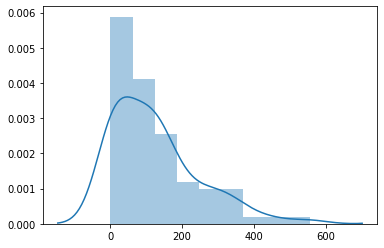

In [50]:
# view number of GPE distribution
n_gpes = [len(x) for x in user_loc_df["locs"].tolist()]
sns.distplot(n_gpes)
plt.show()

## Display entities with displaCy

In [ ]:
from spacy import displacy

In [1]:
# visualize entities
docs = ents_df["spacy"].tolist()[900:902]
vis_docs = [d for d in docs if len(d.ents) > 0]
for i, d in enumerate(vis_docs):
    print("Doc:", i)
    display(HTML(displacy.render(d, style='ent', page=True)))

NameError: name 'ents_df' is not defined